In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

import umap

from collections import Counter

import spacy

# load files and make corpus

In [2]:
with open('hansard-speeches-post2010-lemmatized-agg.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
with open('hansard-speeches-post2010.pkl', 'rb') as f:
    df_orig = pickle.load(f)

In [4]:
MP_party = df_orig[['display_as', 'party']]
MP_party = MP_party.drop_duplicates('display_as').set_index('display_as')

In [5]:
names = [x[2] for x in df.index.values]
parties = [MP_party.loc[MP_name].party for MP_name in names]

In [6]:
corpus = list(df.speech.values)
# corpus = list(df.lemmas.apply(lambda x: " ".join(x)).values)

# speech embedding

In [7]:
from sentence_transformers import SentenceTransformer

# embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embedder = SentenceTransformer('paraphrase-mpnet-base-v2')
# embedder = SentenceTransformer('stsb-mpnet-base-v2') #75 max seq length

## count prop. contributions with word/lemma counts above embedder max input sequence length

max sequence length: 128
wordcounts above 128: 33.859 %
lemmacounts above 128: 22.3978 %


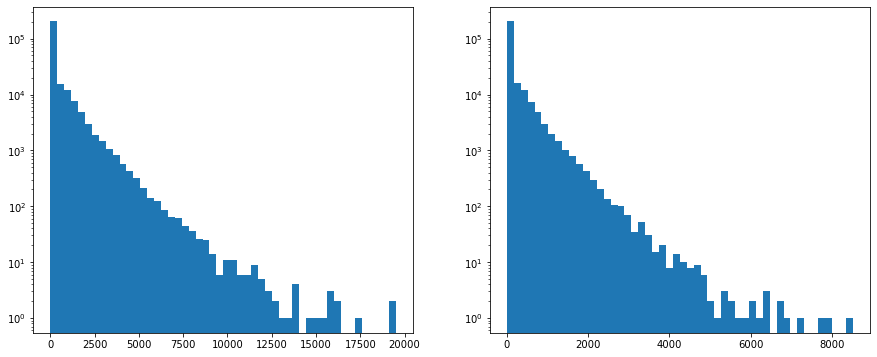

In [8]:
wordcount = df.speech.apply(lambda x: len(x.split())).values
lemmacount = df.lemmas.apply(len).values

max_seq_len = embedder.max_seq_length
print(f'max sequence length: {max_seq_len}')

fig, ax = plt.subplots(1,2,figsize=(15,6))

ax[0].hist(wordcount, bins=50)
ax[0].set_yscale('log')
print(f'wordcounts above {max_seq_len}: {np.around((np.sum(wordcount > max_seq_len) / len(wordcount))*100, 4)} %')

ax[1].hist(lemmacount, bins=50)
ax[1].set_yscale('log')
print(f'lemmacounts above {max_seq_len}: {np.around((np.sum(lemmacount > max_seq_len) / len(lemmacount))*100, 4)} %')

plt.show()

In [9]:
# don't run if loading embeddings
# corpus_embeddings = embedder.encode(corpus)
# corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

In [10]:
# don't run if loading embeddings
# with open('corpus_embeddings.pkl', 'wb') as f:
#     pickle.dump(corpus_embeddings, f)

# run to load embeddings
with open('corpus_embeddings.pkl', 'rb') as f:
    corpus_embeddings = pickle.load(f)

In [11]:
corpus_embeddings.shape

(253820, 768)

## PCA dimensionality reduction

In [12]:
from sklearn.decomposition import PCA
pca = PCA(random_state=26)
pca.fit(corpus_embeddings)

PCA(random_state=26)

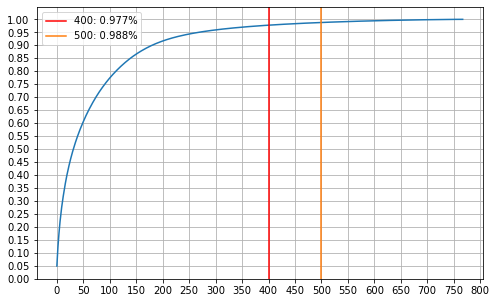

In [13]:
evr = pca.explained_variance_ratio_
cum_evr = [np.sum(evr[:i+1]) for i in range(len(evr))]



fig, ax = plt.subplots(figsize=(8,5))
ax.plot(cum_evr)
ax.grid()
ax.set_xticks(range(0,801,50))
ax.set_yticks(np.arange(0,1.05,0.05))

v = 400
ax.axvline(v, c='r', label=f'{v}: {np.around(cum_evr[v], 3)}%')

v = 500
ax.axvline(v, c='tab:orange', label=f'{v}: {np.around(cum_evr[v], 3)}%')

ax.legend()

plt.show()

In [14]:
# 400 dimensions corresponds to cumulative explained variance ratio of ~98%
embeddings = PCA(n_components=400, random_state=26).fit_transform(corpus_embeddings)

## umap dimensionality reduction

In [15]:
np.unique(parties)

array(['Alliance', 'Conservative', 'Democratic Unionist Party',
       'Green Party', 'Independent', 'Labour', 'Labour (Co-op)',
       'Liberal Democrat', 'Plaid Cymru', 'Respect',
       'Scottish National Party', 'Social Democratic & Labour Party',
       'Speaker', 'Ulster Unionist Party', 'nan'], dtype='<U32')

In [16]:
party_colormap = {
    'Alliance': '#F6CB2F',
    'Conservative': '#0087DC',
    'Democratic Unionist Party': '#D46A4C',
    'Green Party': '#6AB023',
    'Independent': '#DDDDDD',
    'Labour': '#E4003B',
    'Labour (Co-op)': '#E4003B',
    'Liberal Democrat': '#FAA61A',
    'Plaid Cymru': '#008142',
    'Scottish National Party': '#FDF38E',
    'Social Democratic & Labour Party': '#2AA82C',
    'Speaker': '#FFFFFF',
    'Respect': '#46801c',
    'Ulster Unionist Party': '#70147A',
    'nan': '#FFFFFF'
}

c = [party_colormap[str(x)] for x in parties]

In [17]:
# don't run if loading reduced embeddings
# reducer = umap.UMAP(n_neighbors=15, 
#                     min_dist=0,
#                     metric='cosine',
#                     low_memory=True)
# X = reducer.fit_transform(embeddings) # dimension reduced embedding

In [18]:
# don't run if loading reduced embeddings
# with open('umap_embeddings.pkl', 'wb') as f:
#     pickle.dump(X, f)

# run to load reduced embeddings
with open('umap_embeddings.pkl', 'rb') as f:
    X = pickle.load(f)

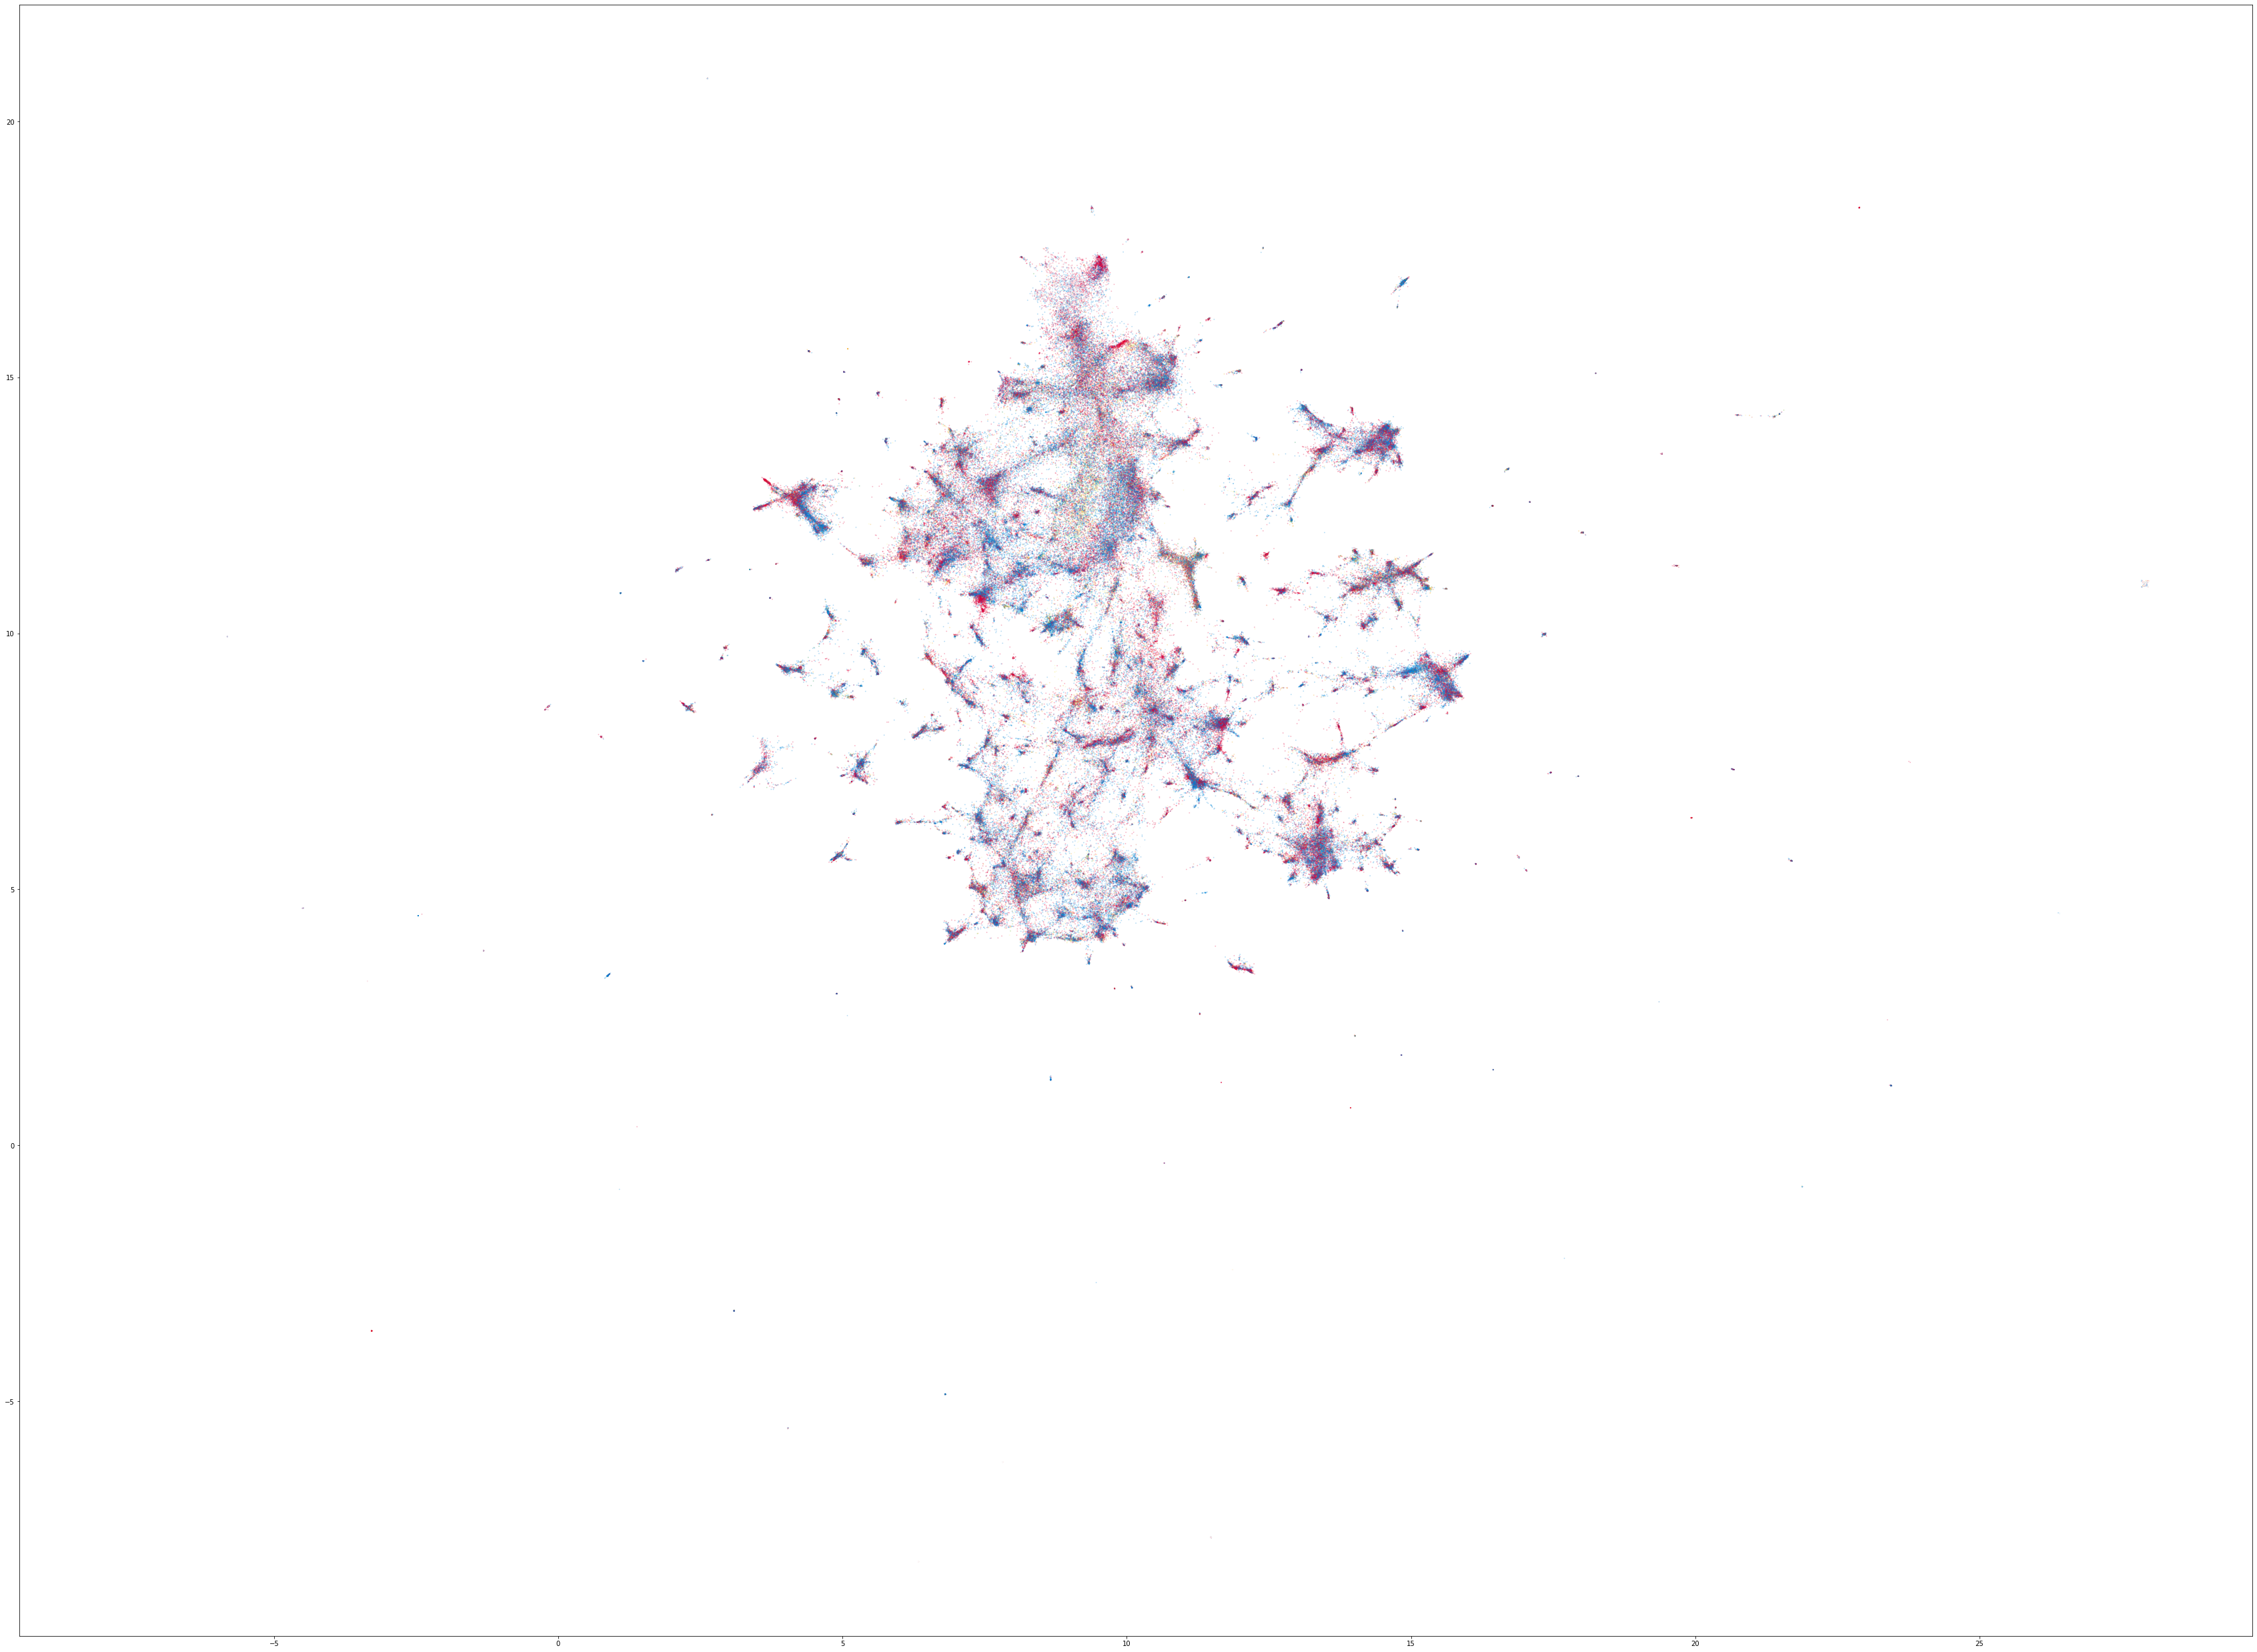

In [19]:
plt.figure(figsize=(60,45))
plt.scatter(X[:,0], X[:,1], s=1, alpha=.2, c=c)#, edgecolors='k', linewidth=0)
# plt.savefig('pp-mpnet-bv2-pca400-nn15-md0-cosine_2.png', dpi=150)
plt.show()

# clustering

In [20]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=20,
                            min_samples=25,
                            cluster_selection_epsilon=0.04,
                            cluster_selection_method='eom')

cluster_labels = clusterer.fit_predict(X)

In [21]:
label_map = np.random.choice(np.arange(len(np.unique(cluster_labels)) - 1), 
                             len(np.unique(cluster_labels)) - 1,
                             replace=False)
label_map = {o:n for o,n in zip(np.arange(len(label_map)), label_map)}
label_map[-1] = -1

cluster_labels = np.array([label_map[x] for x in cluster_labels])

<ipython-input-22-25b25039f68b>:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("rainbow"))
  cmap.set_under('black')  # Color for values less than vmin


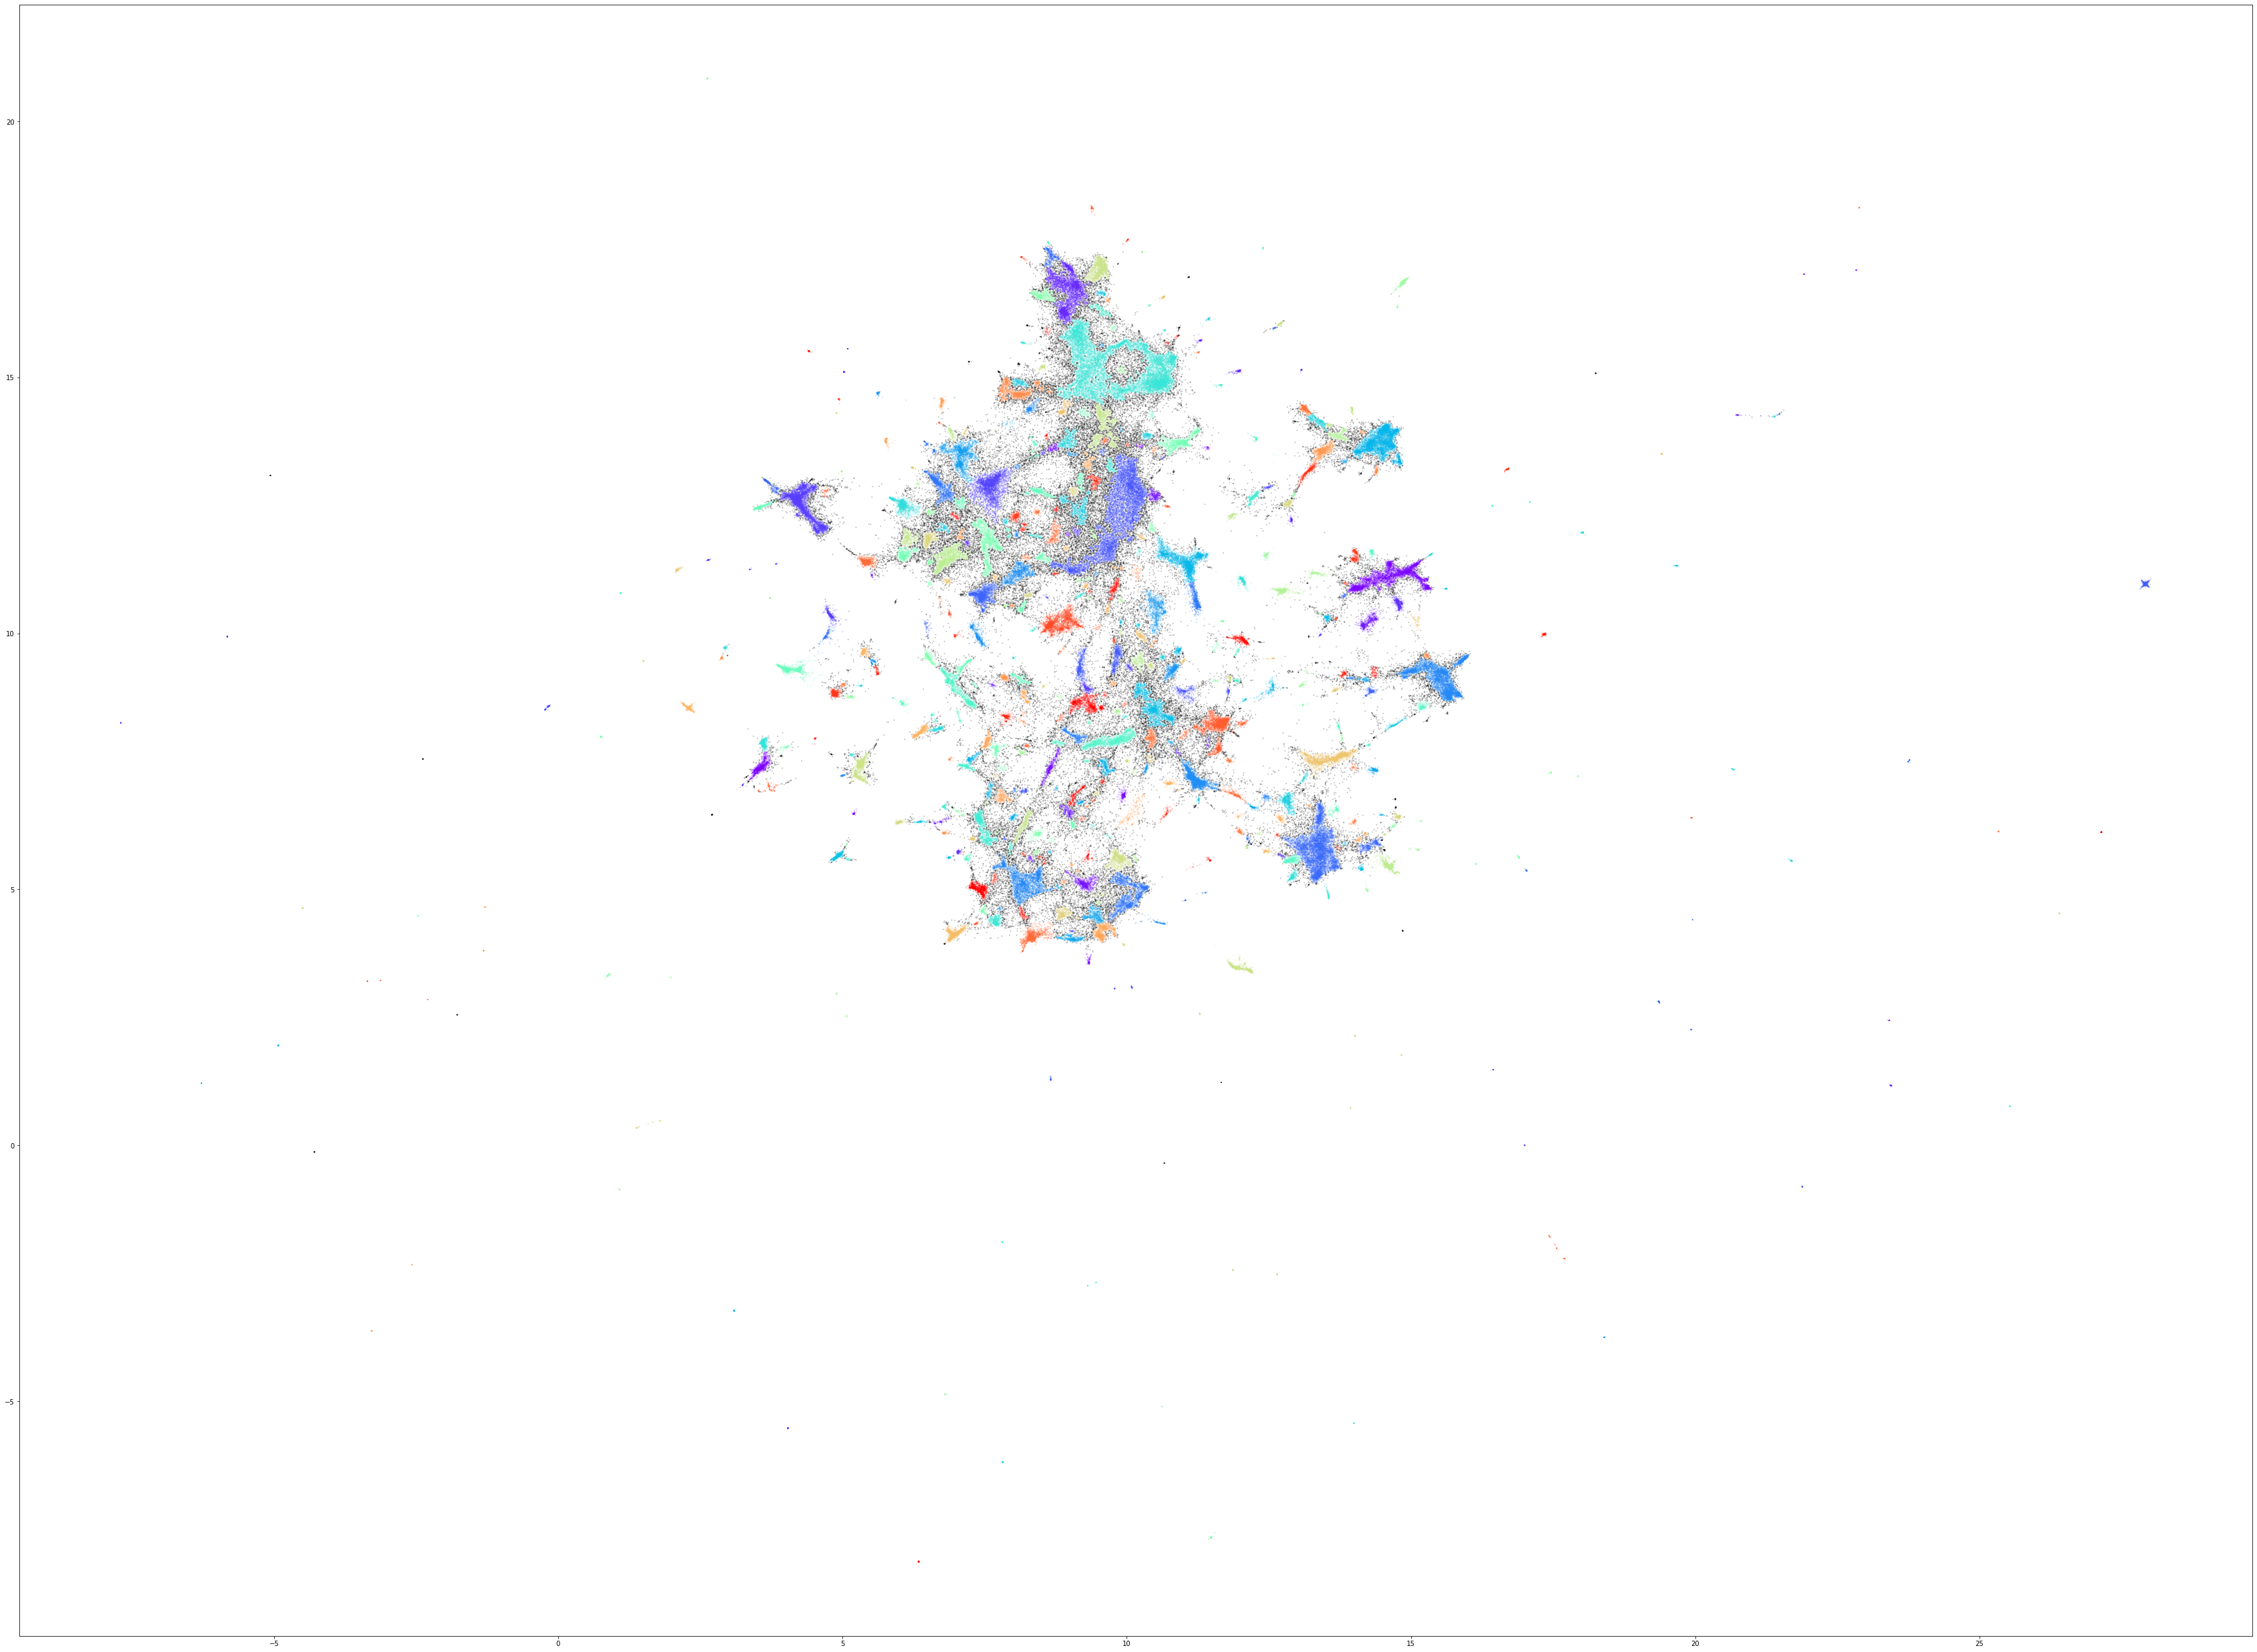

In [22]:
cmap = plt.get_cmap('rainbow')
cmap.set_under('black')  # Color for values less than vmin

plt.figure(figsize=(60,45))
plt.scatter(X[:,0], X[:,1], 
            s=1, alpha=.2, c=cluster_labels,
            cmap=cmap, vmin=0)#, edgecolors='k', linewidth=0)
# plt.savefig('pp-mpnet-bv2-pca400-nn15-md0-cosine_hdbscan3.png', dpi=200)
plt.show()

## plot centroid of each cluster

In [31]:
df_proj = pd.DataFrame(X)
df_proj['cluster'] = cluster_labels

In [32]:
df_clusters = df_proj.groupby('cluster').agg({0: ['mean'], 1: ['mean'], 'cluster':[len]})

In [33]:
X_centroids = df_clusters[[0,1]].values[1:]
cluster_size = df_clusters['cluster'].values[1:]

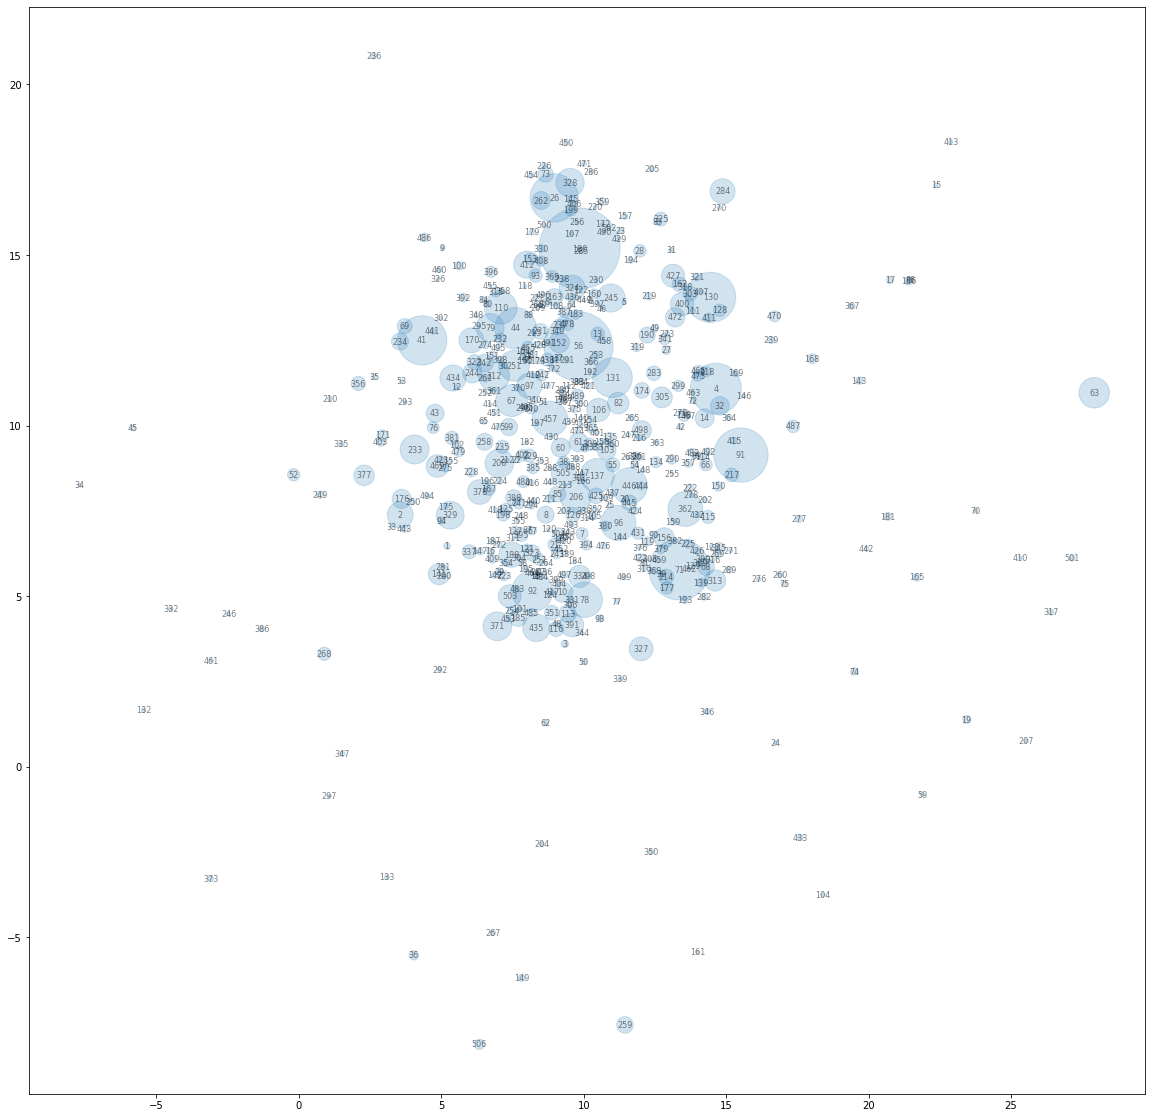

In [45]:
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(X_centroids[:,0], X_centroids[:,1], s=cluster_size/2, alpha=0.2)
for i, txt in enumerate(df_clusters.index.values[1:]):
    ax.annotate(txt, 
                (X_centroids[i,0], X_centroids[i,1]),
                ha='center', va='center',
                fontsize=8,
                alpha=0.5
               )

## analyse clusters

### largest and smallest clusters

In [23]:
cluster_sizes = Counter(cluster_labels)

In [24]:
print(cluster_sizes.most_common()[:10])
print('\r')
print(cluster_sizes.most_common()[-10:])

[(-1, 54782), (180, 13161), (56, 9553), (71, 7465), (91, 5894), (4, 5200), (130, 5040), (41, 4865), (26, 4672), (44, 3456)]

[(122, 22), (468, 22), (46, 22), (462, 21), (311, 21), (129, 20), (279, 20), (404, 20), (189, 20), (502, 20)]


In [25]:
t = 200
clusters_over_t = [x[0] for x in cluster_sizes.most_common() if x[1]>=t]

n = 5
ids = np.random.choice(clusters_over_t, n, replace=False)
sample = [(x, cluster_sizes[x]) for x in ids]
for x in sample:
    print(x)

(206, 1907)
(309, 301)
(-1, 54782)
(115, 351)
(324, 1349)


### analyse text of cluster

In [26]:
nlp = spacy.load("en_core_web_sm")

In [50]:
def analyse_cluster(cluster_id):
    speech_ids = np.where(cluster_labels == cluster_id)
    cluster_rows = df.iloc[speech_ids]

    cluster_word_freq = Counter(" ".join(cluster_rows.speech.values).split()).most_common()
    cluster_nonstopword_freq = [x for x in cluster_word_freq if nlp.vocab[x[0].lower()].is_stop == False and nlp.vocab[x[0]].is_alpha == True]

    cluster_heading_word_freq = Counter(cluster_rows.reset_index().heading.str.lower().str.split().apply(pd.Series).stack().values).most_common()
    cluster_heading_nonstopword_freq = [x for x in cluster_heading_word_freq if nlp.vocab[x[0].lower()].is_stop == False and nlp.vocab[x[0]].is_alpha == True]
    
    return cluster_rows, cluster_nonstopword_freq, cluster_heading_nonstopword_freq

In [188]:
r = {} # 'rows': the dataframe rows of a cluster k
s = {} # 'speeches': the most common non-stopwords in the speeches of cluster k
h = {} # 'headings': the most common non-stopwords in the headings of cluster k

#### "cross" on plot left

In [189]:
ids = [41, 69, 234]

for i in ids:
    res = analyse_cluster(i)
    r[i] = res[0]
    s[i] = res[1]
    h[i] = res[2]

In [195]:
for i, n in enumerate(ids):
    print(n)
    for el in s[n][:10]:
        print(el)
    print('\n')

41
('housing', 10626)
('people', 7008)
('local', 6352)
('Government', 6200)
('homes', 5153)
('new', 4086)
('right', 3981)
('Friend', 3917)
('Minister', 3400)
('need', 3300)


69
('people', 861)
('housing', 705)
('bedroom', 699)
('tax', 492)
('Government', 461)
('Minister', 324)
('local', 257)
('social', 246)
('discretionary', 239)
('policy', 203)


234
('people', 1096)
('rough', 765)
('homelessness', 743)
('Government', 648)
('local', 632)
('homeless', 584)
('sleeping', 528)
('housing', 508)
('support', 437)
('Friend', 350)




In [196]:
for i, n in enumerate(ids):
    print(n)
    for el in h[n][:10]:
        print(el)
    print('\n')

41
('local', 1875)
('government', 1812)
('communities', 1751)
('housing', 1353)
('bill', 724)
('planning', 587)
('questions', 549)
('topical', 548)
('house', 513)
('day', 426)


69
('housing', 171)
('benefit', 123)
('day', 107)
('opposition', 105)
('pensions', 90)
('work', 89)
('allotted', 83)
('penalty', 53)
('topical', 52)
('questions', 52)


234
('local', 266)
('government', 261)
('communities', 257)
('homelessness', 192)
('rough', 77)
('homeless', 71)
('people', 66)
('sleeping', 66)
('deaths', 56)
('bill', 55)




* all relate to housing
* from inspection of parties plot, cluster 69 more 'labour'
* cluster 69 headings relate more to housing benefit than other two clusters
* cluster 69 speeches: high frequency of 'bedroom' and 'tax' (a reform to the welfare system the Labour party opposed)

#### small large cluster on far right

In [197]:
i = 63
r[i], s[i], h[i] = analyse_cluster(i)

In [198]:
s[i][:10]

[('rose', 1869),
 ('like', 2),
 ('outside', 2),
 ('allied', 1),
 ('Mr', 1),
 ('similarities', 1),
 ('suffered', 1),
 ('point', 1),
 ('simply', 1),
 ('wanted', 1)]

* "noise": mostly just "rose -", included in Hansard to indicate an MP standing to signal desire to speak

#### large cluster towards bottom

In [199]:
i = 259
r[i], s[i], h[i] = analyse_cluster(i)

In [200]:
s[i][:10]

[('rose', 1081),
 ('time', 22),
 ('read', 21),
 ('Second', 21),
 ('Friday', 21),
 ('Liberal', 5),
 ('like', 4),
 ('work', 4),
 ('Government', 4),
 ('Democrats', 4)]

* "noise": mostly just "rose -", included in Hansard to indicate an MP standing to signal desire to speak
* in addition, parliamentary procedural text relating to bills / amendments

#### 327

In [201]:
i = 327
r[i], s[i], h[i] = analyse_cluster(i)

In [202]:
s[i][:10]

[('fire', 2939),
 ('Government', 1409),
 ('people', 1167),
 ('right', 1019),
 ('Minister', 966),
 ('work', 928),
 ('local', 880),
 ('Grenfell', 837),
 ('safety', 803),
 ('Friend', 795)]

In [203]:
h[i][:10]

[('tower', 337),
 ('grenfell', 311),
 ('fire', 269),
 ('government', 253),
 ('local', 243),
 ('communities', 232),
 ('safety', 170),
 ('questions', 139),
 ('topical', 138),
 ('department', 102)]

In [204]:
x = r[i].sample().speech
print(x.values[0][:1000])
x

 (Urgent Question): To ask the Under-Secretary of State for Communities and Local Government, the hon. Member for Bromley and Chislehurst (Robert Neill) if he will make a statement on what the Government are doing to halt the dangerous situation in prospect in London of industrial action by firefighters over the bonfire period. I thank the Minister for his response to my question and for the answer to my letter of 15 October, which arrived two hours ago by e-mail.I agree that no one wants to see the strikes, but the House should remember that when such strikes take place, the firefighters' loved ones are in as much danger as the rest of their community. No one takes these decisions lightly, and as the hon. Gentleman knows, I know, because I have been there.What is Mayor Johnson doing to try to resolve the dispute? Can the Minister confirm that new shift patterns have been agreed in other parts of the country after negotiation by the Fire Brigades Union with chief fire officers and loca

date        heading                                                          display_as     
2010-10-26  ELECTORAL COMMISSION COMMITTEE Firefighters (Industrial Action)  Jim Fitzpatrick     (Urgent Question): To ask the Under-Secretary...
Name: speech, dtype: object

In [205]:
r_ = r[i].reset_index()
r_

,date,heading,display_as,speech,lemmas
0,2010-06-03,Business of the House,Mark Lancaster,I pay tribute to the courage and dedication of...,"[pay, tribute, courage, dedication, firefighte..."
1,2010-07-14,PRIME MINISTER Engagements,Lilian Greenwood,Will the Prime Minister guarantee that firefig...,"[prime, minister, guarantee, firefighter, poli..."
2,2010-07-14,RETAINED FIREFIGHTERS,Bob Neill,It is a pleasure to respond to this debate. I ...,"[pleasure, respond, debate, congratulate, hon,..."
3,2010-07-14,RETAINED FIREFIGHTERS,Brandon Lewis,I agree with my hon. Friend's comment about fi...,"[agree, hon, friend, comment, fire, safety, no..."
4,2010-07-14,RETAINED FIREFIGHTERS,Chris White,My hon. Friend the Member for North Warwickshi...,"[hon, friend, member, north, warwickshire, dan..."
...,...,...,...,...,...
1134,2019-10-30,Grenfell Tower Inquiry,Steve Reed,The Government have never fully accepted their...,"[government, fully, accept, responsibility, fa..."
1135,2019-10-30,Grenfell Tower Inquiry,Theresa May,I thank the Government for scheduling this deb...,"[thank, government, schedule, debate, give, ho..."
1136,2019-10-30,Northern Ireland Budget Bill,Jim Shannon,My right hon. Friend has outlined a number of ...,"[right, hon, friend, outline, number, town, fi..."
1137,2019-10-30,Prime Minister Engagements,Boris Johnson,"Immediately after questions today, I will open...","[immediately, question, today, open, debate, g..."


In [206]:
(len(r_[~(r_.speech.str.lower().str.contains('fire') | \
     r_.speech.str.lower().str.contains('grenfell') | \
     r_.speech.str.lower().str.contains('cladding') | \
     r_.heading.str.lower().str.contains('fire') | \
     r_.heading.str.lower().str.contains('grenfell') | \
     r_.heading.str.lower().str.contains('cladding'))]) / len(r_)) * 100

4.741000877963126

<AxesSubplot:xlabel='date'>

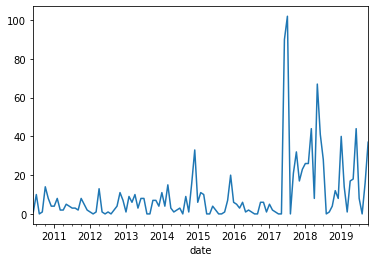

In [211]:
r_.set_index('date').resample('M').count().heading.plot()

* relates to fire service and especially grenfell tower
* only 4.7% of entries don't have 'fire', 'grenfell', or 'cladding' in heading or text

#### 487 - fairly large dense cluster just to right of bulk

In [207]:
i = 487
r[i], s[i], h[i] = analyse_cluster(i)

In [208]:
s[i][:10]

[('smoking', 809),
 ('tobacco', 757),
 ('people', 663),
 ('health', 457),
 ('Government', 432),
 ('public', 313),
 ('packaging', 303),
 ('Minister', 287),
 ('children', 277),
 ('Member', 246)]

In [209]:
h[i][:10]

[('tobacco', 144),
 ('health', 86),
 ('packaging', 83),
 ('business', 53),
 ('house', 53),
 ('products', 44),
 ('bill', 37),
 ('plan', 32),
 ('smoking', 31),
 ('topical', 30)]

<AxesSubplot:xlabel='date'>

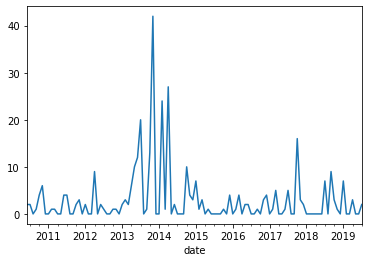

In [210]:
r[i].reset_index().set_index('date').resample('M').count().heading.plot()

* smoking & tobacco

#### largest cluster close to 487: 91

hypothesis - will be related to public health due to proximity to 487 (smoking)

In [212]:
i = 91
r[i], s[i], h[i] = analyse_cluster(i)

In [216]:
s[i][:15]

[('rail', 4878),
 ('Friend', 4476),
 ('Government', 4430),
 ('right', 3732),
 ('new', 3498),
 ('Secretary', 3458),
 ('line', 3123),
 ('people', 3038),
 ('investment', 2915),
 ('Minister', 2886),
 ('State', 2835),
 ('local', 2489),
 ('need', 2373),
 ('Member', 2286),
 ('work', 2051)]

In [217]:
h[i][:15]

[('transport', 2523),
 ('rail', 1686),
 ('topical', 696),
 ('questions', 696),
 ('business', 668),
 ('house', 603),
 ('speed', 475),
 ('high', 474),
 ('infrastructure', 380),
 ('bill', 375),
 ('line', 317),
 ('investment', 305),
 ('wales', 294),
 ('main', 278),
 ('coast', 268)]

In [218]:
r[i].sample(5)

,,,speech,lemmas
date,heading,display_as,,
2015-09-16,WALES Great Western Line,Geraint Davies,Will the Secretary of State give a cast-iron g...,"[secretary, state, cast, iron, guarantee, revi..."
2011-11-23,WALES Fuel Prices,Jessica Morden,For commuters and businesses in my constituenc...,"[commuter, business, constituency, high, fuel,..."
2017-11-23,INTERNATIONAL TRADE Ministerial Discussions,Ian Lucas,What recent discussions he has had with the Se...,"[recent, discussion, secretary, state, busines..."
2017-10-26,COMMITTEES RHS Wisley/A3,Paul Beresford,I offer special thanks to the Minister. I know...,"[offer, special, thank, minister, know, past, ..."
2012-03-08,Business of the House Rail Reform,Gavin Williamson,The ticket office at Codsall station was close...,"[ticket, office, codsall, station, close, numb..."


* rail infrastructure & investment

#### 415 & 217 - neighbours of 91

In [219]:
i = 415
r[i], s[i], h[i] = analyse_cluster(i)

In [220]:
r[i].sample(10)

,,,speech,lemmas
date,heading,display_as,,
2019-06-13,TRANSPORT Transport Connectivity: North of England,Andy McDonald,"Thirty-three northern newspapers, including th...","[thirty, northern, newspaper, include, manches..."
2016-03-09,CABINET OFFICE Civil Service: Policy Making,Louise Haigh,We know that the Minister’s friend the Paymast...,"[know, minister, friend, paymaster, general, c..."
2014-06-24,TREASURY Topical Questions,Mike Kane,May I remind the Chancellor that it was actual...,"[remind, chancellor, actually, daniel, adamson..."
2016-01-19,TREASURY Northern Powerhouse,Dennis Skinner,Does the northern powerhouse occur in Redcar w...,"[northern, powerhouse, occur, redcar, steel, i..."
2016-10-24,COMMUNITIES AND LOCAL GOVERNMENT Topical Questions,Lucy Powell,The northern powerhouse project has brought mu...,"[northern, powerhouse, project, bring, need, i..."
2018-06-25,BUSINESS OF THE HOUSE National Policy Statement: Airports,Mike Kane,Will the hon. Gentleman give way? It was the M...,"[hon, gentleman, way, mancunian, entrepreneur,..."
2015-09-16,WALES Northern Powerhouse,Alun Cairns,The northern powerhouse is a fantastic opportu...,"[northern, powerhouse, fantastic, opportunity,..."
2017-04-24,COMMUNITIES AND LOCAL GOVERNMENT Northern Powerhouse,Jason McCartney,What steps his Department is taking to support...,"[step, department, take, support, northern, po..."
2015-06-30,"BUSINESS, INNOVATION AND SKILLS Industrial Strategy",David Jones,The Government’s northern powerhouse strategy ...,"[government, northern, powerhouse, strategy, p..."


In [221]:
h[i][:10]

[('northern', 30),
 ('powerhouse', 29),
 ('local', 19),
 ('government', 19),
 ('treasury', 19),
 ('business', 18),
 ('communities', 18),
 ('house', 16),
 ('prime', 10),
 ('minister', 10)]

* northern powerhouse rail project